In [20]:
import torch
import torch.nn as nn

import math
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import uniform_filter1d
import sys
import time
import cv2

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [21]:
# load map data
filename = '/home/oscar_palfelt/MSc_thesis/LearnedSamplingDistributions/narrowDataFile.txt'

obsData = np.unique(np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[6, 7, 9, 10, 12, 13]), axis=0)
numEntries = obsData.shape[0]

In [22]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = np.copy(obsData)
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:2]
    gap2 = conditions[j,2:4]
    gap3 = conditions[j,4:6]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
end = time.time();
print('Time: ', end-start)
    

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Time:  10.830914735794067


In [87]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def propagate(start, control, duration, state):
    # global exploredStates
    # exploredStates = np.vstack((exploredStates, np.array([[state.getX(), state.getY(), state.getYaw()]])))

    state.setX(start.getX() + v * duration * np.cos(start.getYaw()))
    state.setY(start.getY() + v * duration * np.sin(start.getYaw()))
    state.setYaw(start.getYaw() + control[0] * duration)
    #state.setYaw(start.getYaw() + v / L * np.tan(control[0]) * duration)


def problemDef(sampleCtrl=False):
    # construct the state space we are planning in
    #space = ob.DubinsStateSpace(turningRadius=0.07)
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    if sampleCtrl:
        # create a control space
        cspace = oc.RealVectorControlSpace(space, 1)

        # set the bounds for the control space
        cbounds = ob.RealVectorBounds(1)
        cbounds.setLow(-1.5)
        cbounds.setHigh(1.5)
        cspace.setBounds(cbounds)

        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()
        si.setPropagationStepSize(.07)
        planner = oc.EST(si)
    else:

        # define a simple setup class
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))
    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState, simplify=False):

    #space = ob.DubinsStateSpace(turningRadius=0.07)
    space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(2.5)
    exactSolTerminationCondition = ob.exactSolnPlannerTerminationCondition(planObj.getProblemDefinition())
    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.05)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if simplify and solved:
        planObj.simplifySolution()


In [30]:
class PurePursuitController():

    k = 0.6  # look forward gain
    Lfc = 0.08  # look-ahead distance
    K_p = 1.2  #TODO speed control propotional gain
    K_i = 5.0  #TODO speed control integral gain
    K_d = 0.008  # speed control derivitive gain
    L = 0.324  # [m] wheel base of vehicle

    def __init__(self):
        self.traj_x = []
        self.traj_y = []
        self.target = None
        self.max_vel = 0.7
        # initialize with 0 velocity
        self.target_velocity = 0.0
        self.last_index = 0
        self.last_d = 100
        self.dt = 0.01
        self.vel_error_int_sum = 0
        self.vel_error = np.array([0])  
        self.vel_error_int = np.array([0]) 
        self.vel_error_der = np.array([0]) 
        self.is_finished = False

    def compute_control(self, state, target=None):
        steering = self.compute_steering(state, target)
        velocity = self.compute_velocity(state)
        return steering

    def compute_steering(self, state, target=None):
        if target is None:
            self.find_target(state)
        else:
            # allow manual setting of target
            self.target = target

        tx, ty = self.target
        alpha = np.arctan2(ty - state.y, tx - state.x) - state.yaw
        if state.v < 0:  # back
            alpha = np.pi - alpha
        Lf = self.k * state.v + self.Lfc
        delta = np.arctan2(2.0 * self.L * np.sin(alpha) / Lf, 1.0)
        return delta
                                   
    def compute_velocity(self, state):
        if self.is_finished:
            # stop moving if trajectory done
            return 0.0
        else:
            # speed control
            # Append the errors to the lists2
            self.vel_error     = np.append(self.vel_error      , self.target_velocity - state.v)
            self.vel_error_int = np.append(self.vel_error_int  , self.vel_error_int[-1] + self.vel_error[-1] * self.dt)
            self.vel_error_der = np.append(self.vel_error_der  , (self.vel_error[-1] - self.vel_error[-2]) / self.dt)

            P = self.vel_error[-1] * self.K_p
            I = self.vel_error_int[-1] * self.K_i
            D = self.vel_error_der[-1] * self.K_d

            correction = P + I + D

            # Saturating the velocity at a max velocity
            return self.target_velocity + min(correction, 0)

    def find_target(self, state):
        ind = self._calc_target_index(state)
        self.last_index = ind
        tx = self.traj_x[ind]
        ty = self.traj_y[ind]
        self.target = (tx, ty)

    def _calc_target_index(self, state):
        # search nearest point index
        dx = [state.x - icx for icx in self.traj_x]
        dy = [state.y - icy for icy in self.traj_y]
        d = [abs(np.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
        ind = d.index(min(d))
        dist = 0.0
        Lf = self.k * state.v + self.Lfc

        # search look ahead target point index
        while Lf > dist and (ind + 1) < len(self.traj_x):
            dx = self.traj_x[ind + 1] - self.traj_x[ind]
            dy = self.traj_y[ind + 1] - self.traj_y[ind]
            dist += np.sqrt(dx ** 2 + dy ** 2)
            ind += 1

        # terminating condition
        if ind >= len(self.traj_x) - 1 and d[-1] < 0.08:
            self.is_finished = True

        return ind


class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

Debug:   RRTstar: Planner range detected to be 0.596436
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.37 in 98 iterations (37 vertices in the graph)
Info:    RRTstar: Created 36 new states. Checked 666 rewire options. 1 goal states in tree. Final solution cost 1.366
Info:    Solution found in 0.006170 seconds
Info:    SimpleSetup: Path simplification took 0.002406 seconds and changed from 4 to 2 states
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 2.08 in 409 iterations (198 vertices in the graph)
Info:    RRTstar: Created 197 new states. Checked 19503 rewire options. 1 goal states in tree. Final solution cost 2.079
Info:    Solution found in 0.075231 seconds
Debug:   The solution path w

         at line 77 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/src/SpaceInformation.cpp


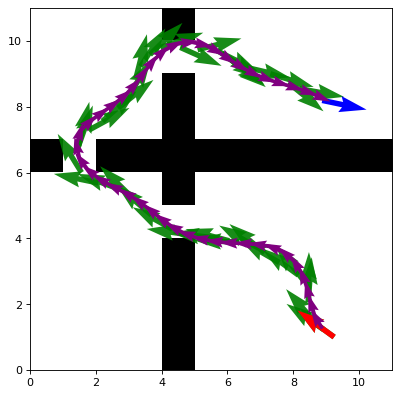

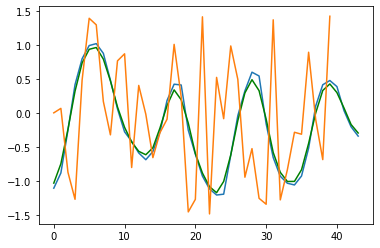


 
 (45, 4)

 
 (45, 6)


In [93]:
# generate planning scenario, plan, and perform path following

nData = 1
minDistThreshold = 0.5 # minimum distance threshold betwen start/goal
pdef = problemDef(sampleCtrl=False)
pdef_ctrl = problemDef(sampleCtrl=True)
maxCtrlIter = 400

dt = 0.4 # controller time step
L = 0.2 # vehicle length constant
v =  0.1 # vehicle speed

trajSamples = np.zeros(shape=(1, 4)) # x, y, yaw, steer
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3))
obstacleData = np.zeros(shape=(1, obsData.shape[1]))
data = np.zeros(shape=(1, trajSamples.shape[1] + initData.shape[1] + goalData.shape[1] + obstacleData.shape[1]))

# exploredStates = np.zeros(shape=(1, 3))

plotPaths = True

nPlans = 0
while nPlans < nData:
    
    occGrid = conditionsOcc[nPlans].reshape(gridSize, gridSize)
    inflatedGrid = np.floor(cv2.blur(occGrid, ksize=(3,3)))

    # generate starting point and yaw using simple planner
    while True:
        
        while True: # randomize starting coordinates
            start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
            vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
            uGoal = int(np.floor(goal[0] * gridSize)) # right pointing image axis
            vGoal = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
            if np.linalg.norm(start[:2] - goal[:2]) > minDistThreshold and inflatedGrid[vStart,uStart] > 0 and inflatedGrid[vGoal,uGoal] > 0:
                break

        pdef.clear()
        plan(pdef, initState=start, goalState=goal, simplify=True)
        if pdef.getProblemDefinition().hasExactSolution() and not np.any(goalData[-1,:2] == goal[:2]): # ignore paths that consequtively start in the same pose
            break

    ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
    if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.01:
        ssol = ssol[1:]
    if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.01:
        ssol = ssol[:-1]

    if ssol.shape[0] > 0:

        start_dxdy = ssol[0, :2] - start[:2]; goal_dxdy = goal[:2] - ssol[-1, :2]
        start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)
        start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
        goal[-1] = np.sign(int(goal_xydot[-1] > 0)- 0.5) * np.arccos(np.dot(goal_xydot / np.linalg.norm(goal_xydot), [1, 0]))

        pdef_ctrl.clear()
        plan(pdef_ctrl, initState=start, goalState=goal)
        if not pdef_ctrl.getProblemDefinition().hasExactSolution():
            continue

        csol = np.loadtxt(StringIO(pdef_ctrl.getProblemDefinition().getSolutionPath().printAsMatrix()))


        controller = PurePursuitController()
        state = VehicleState()

        controller.traj_x = np.append(csol[:,0], goal[0])
        controller.traj_y = np.append(csol[:,1], goal[1])

        state.x = start[0]; state.y = start[1]; state.yaw = start[2]; state.v = v
        statelist = [[state.x, state.y, state.yaw, 0]]
        delta = controller.compute_control(state)

        ctrliter = 0
        while not controller.is_finished and ctrliter < maxCtrlIter:
            #delta = controller.compute_control(state)
            delta = (delta + controller.compute_control(state)) / 2 # helps smoothen steering input

            state.x += v * np.cos(state.yaw) * dt
            state.y += v * np.sin(state.yaw) * dt
            state.yaw += v / L * np.tan(delta) * dt

            statelist.append([state.x, state.y, state.yaw, delta])
            ctrliter += 1

        if ctrliter >= maxCtrlIter:
            continue

        statelist = statelist[1:] # remove first sample with 0 steering angle
        nSteps = len(statelist)
        statearr = np.array(statelist).reshape(-1).reshape(nSteps, 4)

        trajSamples = np.vstack((trajSamples, statearr)) # x, y, yaw
        initData = np.vstack((initData, np.tile(start, reps=(nSteps, 1)))) # x, y, yaw
        goalData = np.vstack((goalData, np.tile(goal, reps=(nSteps, 1))))
        obstacleData = np.vstack((obstacleData, np.tile(obsData[nPlans], reps=(nSteps, 1))))

        if plotPaths:
            fig1 = plt.figure(figsize=(10,6), dpi=80)
            ax1 = fig1.add_subplot(111, aspect='equal')
            ax1.quiver(csol[:, 0] * gridSize, csol[:, 1] * gridSize, np.cos(csol[:, 2]), np.sin(csol[:, 2]), color="green", scale=8.0, width=0.015, alpha=0.9)
            ax1.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
            ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
            ax1.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
            ax1.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
            plt.show()

            plt.plot(np.arange(nSteps), statearr[:, 3])
            plt.plot(np.arange(nSteps), uniform_filter1d(statearr[:, 3], size=3, origin=0, mode='nearest', axis=0), color='green')
            plt.plot(np.arange(csol.shape[0]), csol[:,3])
        
            plt.show()

        if nPlans % 300 == 0: # alleviate stacking of large matrices
            print("\n \n", np.shape(trajSamples))
            print("\n \n", np.shape(obstacleData))

            data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1))) 

            if nPlans % 3000 == 0: # save progress in case of error
                np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollow_n' + str(nPlans), data[1:], delimiter=',', fmt='%1.6f')

            # alleviate stacking of large matrices
            trajSamples = np.zeros(shape=(1, 4))
            initData = np.zeros(shape=(1, 3))
            goalData = np.zeros(shape=(1, 3))
            obstacleData = np.zeros(shape=(1, obsData.shape[1]))

        nPlans += 1

In [6]:
print(nPlans)
print(nData)
print(data.shape)

7422
1000000
(218730, 10)


In [7]:
data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:]), axis=1)))
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollowAsd', data[1:], delimiter=',', fmt='%1.6f')

In [ ]:
# animate explored states
dist = np.linalg.norm(np.diff(exploredStates[:,:2], axis=0), axis=1)
plotIdx = np.where(np.abs(dist - 0.1) < 0.1)[0][::100]
print(plotIdx.shape)

def update_plot(i):
    scat = plt.scatter(x[plotIdx[i]:plotIdx[i+1]] * gridSize, y[plotIdx[i]:plotIdx[i+1]] * gridSize, color='C0', s=10, alpha=0.2/np.sqrt(plotIdx.shape[0]))
    return scat

numframes = plotIdx.shape[0] - 1
x, y = exploredStates[:,0], exploredStates[:,1]

fig = plt.figure()
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.xlim([0, gridSize])
plt.ylim([0, gridSize])

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes))

print("saving animation")                            
ani.save('animation.mp4', fps=40)